In [30]:
using FileIO
using Plots
include("splitcell.jl")

remove_small_area

In [ ]:
d16s1 = load(File(format"TIFF", "../mRNA_confocal_hamamatsu-60X-TIRF/20200316/HE7-11-1-80uw-PWM_1_s1.ome.tiff"));

In [97]:
# Get living time
livingtime(stack) = [ sum(stack[:, :, i])>0 for i in 1:size(stack)[3] ]
area_t(stack) = [ sum(stack[:, :, i]) for i in 1:size(stack)[3] ]

# Find long-lived trajactory
function find_time_line(markers_t)
    # search connected components in 3D space 
    shortest_t = 90
    print("Finding connected component")
    @time time_line = label_components( markers_t.>0 )
    line_amount = maximum(time_line)
    # More advanced and fine punch and merge could be done
    # But we just select long living trajactory, remove short-lived one
    living_time =[ livingtime(time_line.==line) for line in 1:line_amount ]
    living_length = [sum(living_time[line]) for line in 1:line_amount]
    # label 0 mean background
    shortlived = living_length .< shortest_t
    longlived_label = (1:line_amount)[.~shortlived]
    #longlived_time = living_time[]
    for line in (1:line_amount)[shortlived]
        time_line .*= (time_line.≠line)
    end
    time_line, longlived_label, living_time[longlived_label]
end

find_time_line (generic function with 1 method)

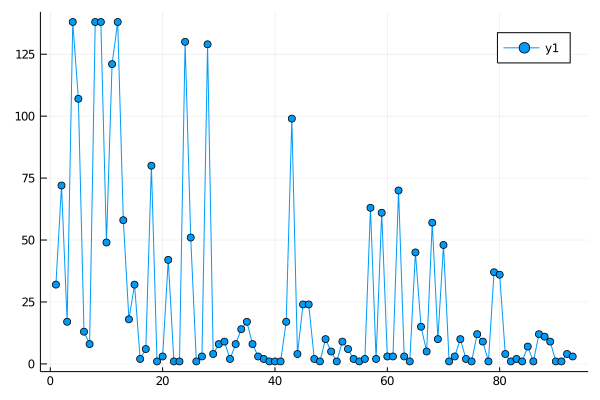

In [56]:
@time time_line, longlived_label, livetime = find_time_line(mask_markers);
plot(sum.(livetime), marker=:circle)

In [36]:
@time time_line_2, longlived_label_2, livingtime_2 = find_time_line(mask_markers_2);

Finding connected component  2.786777 seconds (74 allocations: 2.898 GiB, 0.51% gc time)
 79.684758 seconds (52.22 k allocations: 12.663 GiB, 0.90% gc time)


In [63]:
for i in longlived_label_2
    #save("d16s1_$i.tiff", d16s1[:, :, 14:20:end] .*(time_line_2 .== i))
    #print("saving $i")
end 

saving 4saving 5saving 8saving 9saving 11saving 12saving 13saving 15saving 27saving 31saving 53

In [99]:
@time area_longlived = [area_t( time_line_2 .== i)  for i in longlived_label_2];

  3.206923 seconds (59.03 k allocations: 897.052 MiB, 1.41% gc time)


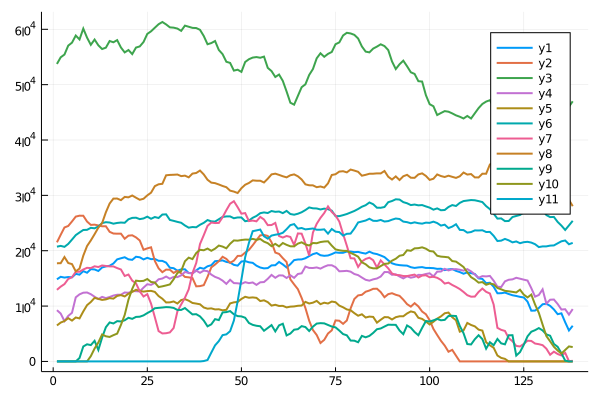

GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to un

In [114]:
plot(area_longlived, lw=2)

In [175]:
time_line_2_old = copy(time_line_2)
longlived_label_2_old = copy(longlived_label_2 )
livingtime_2_old = copy(livingtime_2);

11-element Array{Array{Bool,1},1}:
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [0, 0, 0, 0, 0, 0, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [236]:
time_line_2 = copy(time_line_2_old)
longlived_label_2 = copy(longlived_label_2_old )
livingtime_2 = copy(livingtime_2_old);

In [241]:
#for old_label in old_labels
function split_contacted_cell!(old_time_line::Array{Int64,3}, 
        old_longlived_labels::Array{Int64,1}, old_living_time::Array{Array{Bool,1},1})
    t_len = size(old_time_line)[3]
    println("Detecting contacted branch")
    conn_z_number = []; # mark connected components more than 1
    for label in old_longlived_labels
        branches = time_line_2 .== label
        push!(conn_z_number, [maximum(label_components(branches[:,:, i])) .> 1 for i in 1:t_len])
    end
    contacted_labels = old_longlived_labels[sum.(conn_z_number) .> 10]
    print("Found contacted branch: ")
    println(contacted_labels)
    # if two more connected component touch to at same z slice more than 10 times
    # select area longer than 5e4
    #old_label = longlived_label_2[mean.(area_longlived) .> 5e4 ]
    
    # split 3d branch by split 2d cell slice by slice
    for contacted_label in contacted_labels
        dist_const = 30 # distance constant 
        contacted_branch = old_time_line .==  contacted_label
        dist  = zeros(size( contacted_branch ))
        local_markers = zeros(Bool, size( contacted_branch ))
        println("Splitting branch $contacted_label now")
        for  t in 1:t_len
            dist[:,:, t] = distance_transform(feature_transform(.~contacted_branch[:,:,t]))
            local_markers[:,:,t] = dist[:,:,t] .> dist_const
            #split_water = watershed( .- dist[:,:,t], label_components(markers[:,:,t]))
            # 直接用 dist 可能会错误打断完整轨迹，需额外膨胀
            # 用分水岭 可能会误连，需额外腐蚀
        end
        local_time_line, local_longlived_labels, local_living_time = find_time_line( local_markers );
        println("Reassigning contacted branch $contacted_label ")
        # Assign new label to labels set and update mask
        
        if length(local_longlived_labels) > 0
            #TODO: what if all lines are shorter than 90 after breaking
            # remove old branch, old label, old living time.
            old_time_line .-= (( old_time_line .== contacted_label ).*contacted_label)
            index2remove =  old_longlived_labels .== contacted_label
            deleteat!( old_longlived_labels, index2remove )
            deleteat!( old_living_time, index2remove)
            for i in 1:length(local_longlived_labels)
                global_label = get_unique_label(old_longlived_labels)
                old_time_line .+= ((local_time_line .== local_longlived_labels[i]) .* global_label)
                push!( old_longlived_labels, global_label )
                push!( old_living_time, local_living_time[i] )
                println("Branch $contacted_label -> $global_label")
            end
        end
    end
    old_time_line, old_longlived_labels, old_time_line
end

split_contacted_cell! (generic function with 1 method)

In [242]:
@time split_contacted_cell!(time_line_2, longlived_label_2, livingtime_2);

Detecting contacted branch
Found contacted branch 
[8, 13]
Splitting now
Finding connected component  2.269105 seconds (72 allocations: 2.897 GiB, 0.53% gc time)
Reassigning contacted branch 8 Branch 8 -> 100
Branch 8 -> 101
Branch 8 -> 102
Splitting now
Finding connected component  2.351247 seconds (70 allocations: 2.897 GiB, 0.51% gc time)
Reassigning contacted branch 13 Branch 13 -> 103
117.227676 seconds (563.91 k allocations: 69.905 GiB, 5.34% gc time)


In [224]:
for i in 100:103
    save("d16s1_$i.tiff", d16s1[:, :, 14:20:end] .*(time_line_2 .== i))
    println("saving $i")
end 

saving 100
saving 101
saving 102
saving 103


In [219]:
function get_unique_label(_old_labels)
    i = 101 # start from 100 to distiguish with oldest labels
    while(true)
        if i in _old_labels
            i+=1
        else
            break
        end
    end
    i
end

get_unique_label (generic function with 2 methods)

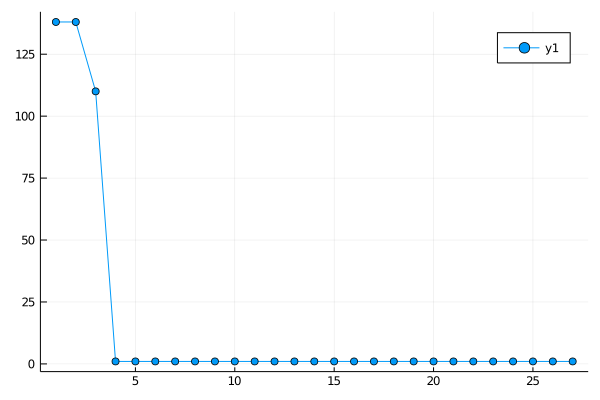

In [93]:
dt_lab = label_components(dt .> 30); # 与细胞大小相关
dt_living = [livingtime(dt_lab.== i) for i in 1:maximum(dt_lab) ];
plot(sum.(dt_living), marker=:circle)

In [53]:
"""
"""
function walking(time_lines)
    
end 

walking

In [ ]:
component_centroids

In [ ]:
"""
Using given mask to export roi of cell 
"""
function pick_cell(time_line)
    height, width = size(imgs[:,:,1]);
    crop_img = zeros(700, 700, length(track)*20);
    for t in 1:length(track)
        x, y = Int.(floor.(track[t]));
        xmin, xmax, ymin, ymax = x-349 , x+350,  y-349, y+350
        if xmin < 1
            xmax = xmax - xmin + 1
            xmin = 1
        end
        if xmax > 1900
            xmin = xmin - (xmax-1900)
            xmax = 1900
        end
        if ymin < 1
            ymax = ymax - ymin +1
            ymin = 1
        end
        if ymax > 1300
            ymin = ymin - (ymax-1300)
            ymax = 1300
        end
        masked_cell= (edge_mask[:,:,t] .== edge_mask[x, y, t] )
        for i in 1:20
            crop_img[:,:,20*(t-1)+i] =(masked_cell.*imgs[:,:,20*(t-1)+i])[xmin:xmax, ymin:ymax]
        end
    end
    crop_img;
end
      